# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2024 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)
</PRE>

## **Homework**
1.   New augmentations under Data Pipeline section within the DogFoodDataModule class.

2.   Image saving process under Visualization section within visualize_images function
3. New neural network and NN parameter numbers under Convolutional Neural Network Definiton section
4. Confusion Matrix at the end of the notebook






Install necessary packages:
* PyTorch Lightning: high-level deep learning library over PyTorch.
* Weights and Biases: library used for logging metrics and model checkpoints.
* Datasets: library for loading datasets from the Hugging Face Hub (https://huggingface.co/datasets).

In [1]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Load the necessary libraries.

In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets

Login to WandB. Make sure that you have a valid WandB account. Ctrl + click on the link, copy the token from the opened page.

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Hyperparameters

In [4]:
# we will use these later for the CNN
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

## Data pipeline

* We will be using the https://huggingface.co/datasets/lewtun/dog_food dataset.
* What is the difference between dataset and dataloader?
* What is the difference between image preprocessing and image augmentations? Look at the transforms. What do we use during training and validation?
* Best practices:
    * Set `num_workers > 0`. A good starting point is the number of CPU cores on your system.
    * If you use a GPU, set `pin_memory = True`. This improves the speed of CPU-to-GPU data transfer.
    * If you want to have a consistent batch_size in all iterations, set `drop_last = True`.
    * During training, set `shuffle = True`, which shuffles the order of frames in the dataset.

In [5]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),

            #new tranformations: Colorjitter, Randomrotation and Gaussianblur
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=20),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),

            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [6]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.34k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

(…)-00000-of-00001-e911c635bb007d15.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

(…)-00000-of-00001-72eb355cf5eb6762.parquet:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

## Visualization
* PyTorch uses channels first representation (batch, channels, height, width) vs channels last (batch, height, width, channels) by default. Keep that in mind during visualization, because matplotlib expects channels last format.

In [7]:
#Save generated figures if save path is provided

def visualize_images(dataset, num_images, num_augmentations, save_path=None):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved visualization to {save_path}")

    plt.show()

Saved visualization to Augmented images.png


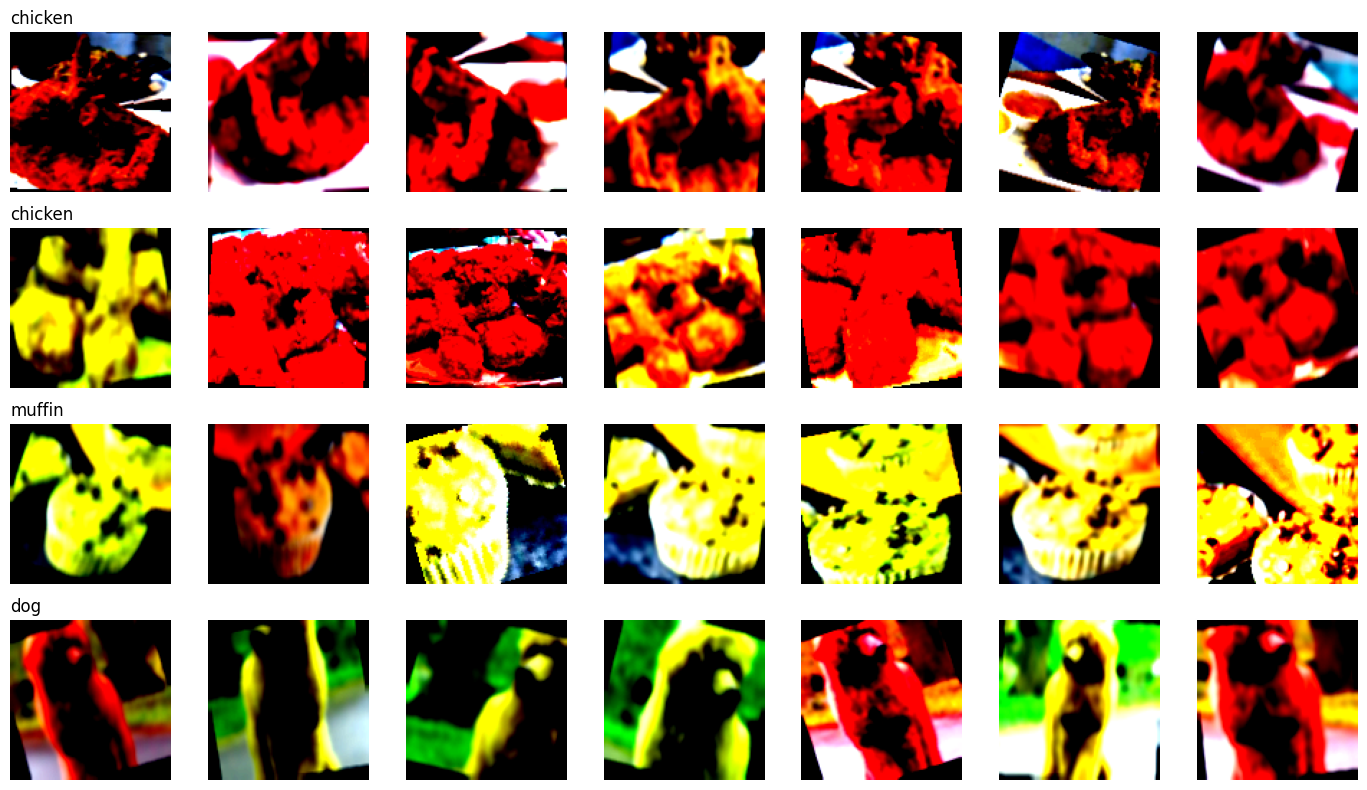

In [8]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=7, save_path="Augmented images.png")

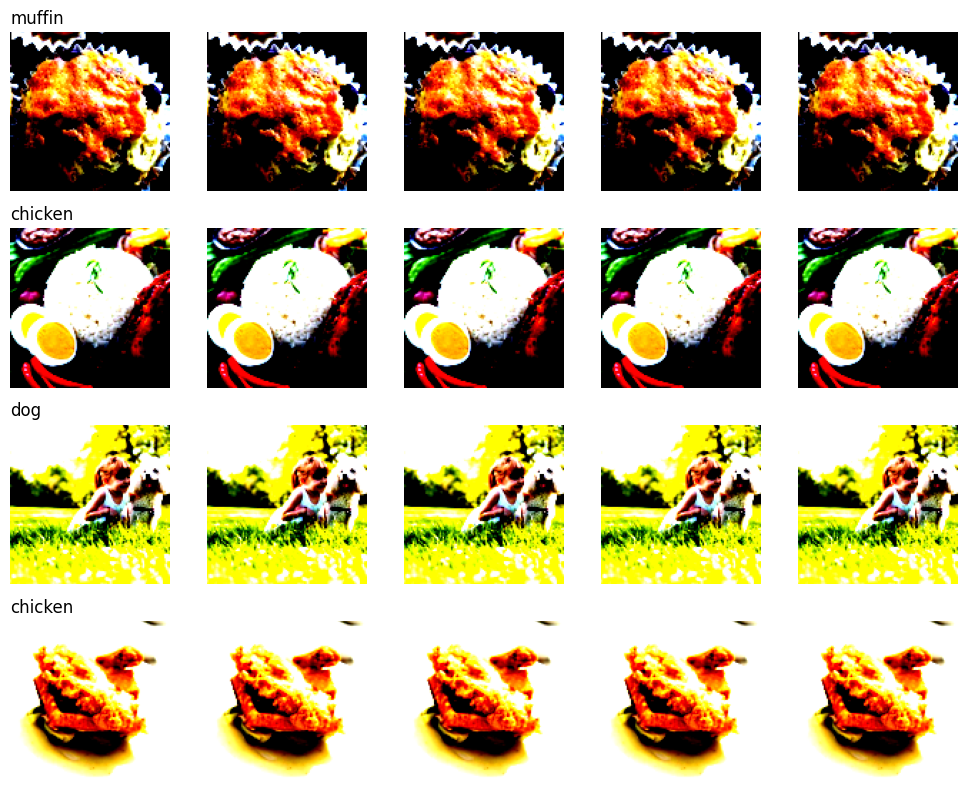

In [9]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

## Classifier Model Definition

In [10]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        # return torch.optim.Adam(self.parameters(), lr=learning_rate)
        return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)


## Convolutional Neural Network Definiton

* Observe our custom CNN.
* What do each of the Conv2d parameters mean?
* What are the output shapes of each layer?
* What is a fully convolutional neural network? What is their advantage?

In [11]:
#Renamed to original_model for differenciation
original_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

#Altered model with batch normalization layers
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# model = torchvision.models.mobilenet_v2(num_classes=num_classes)

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


**Print number of parameters in Original model Vs new model with Batch normalization layers**

In [12]:
original_model = original_model
modified_model = model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Original model parameters:", count_parameters(original_model))
print("Modified model parameters:", count_parameters(modified_model))

Original model parameters: 112771
Modified model parameters: 113283


Best practices:
* Use 16-bit floating point mixed precision for >2x faster training and 2x lower GPU memory consumption.
* If using a PyTorch 2.x on a modern GPU (Volta or Ampere architecture e.g. V100 or A100), compile your neural network.
* For better GPU utilization, use larger batch sizes.

In [13]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

## Training
* We log our metrics using a `WandbLogger`.
* We save our best checkpoints using a `ModelCheckpoint` callback.

In [ ]:
wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: oumaimajribi75 (oumaimajribi75-budapesr-uiversity-of-technology-and-econ). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 113 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.453     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
train_acc_epoch,▁▃▃▃▄▄▄▅▅▆▆▆▆▆▇▆▆▇▆▇▇▇▇███▇███
train_acc_step,▁▃▄▃▃▂▃▅▅▂▄▆▂▅▇▅▆▆▅█▂▃▆▅▅▃▅█▃▇▇▆▅▅▆▇▆▇▇▇
train_loss_epoch,█▇▇▆▆▆▅▅▄▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train_loss_step,█▆▆▆▇█▇▅▅█▆▄▇▄▃▄▃▃▄▃▆▇▃▇▅▆▆▁▇▁▂▃▄▂▄▁▅▃▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
val_acc,▂▂▁▃▃▄▄▄▅▄▄▆▄▅▅▅▆▅▇▅▇▅▇▇▆██▆██
val_loss,█▇█▇▇▆▆▅▅▅▅▄▅▄▄▄▃▄▂▃▃▃▃▂▂▁▁▃▁▁
epoch,29
train_acc_epoch,0.79196
train_acc_step,0.8125


In [ ]:
# if you stop your training early, run this line manually, to finish the wandb run
# wandb.finish()

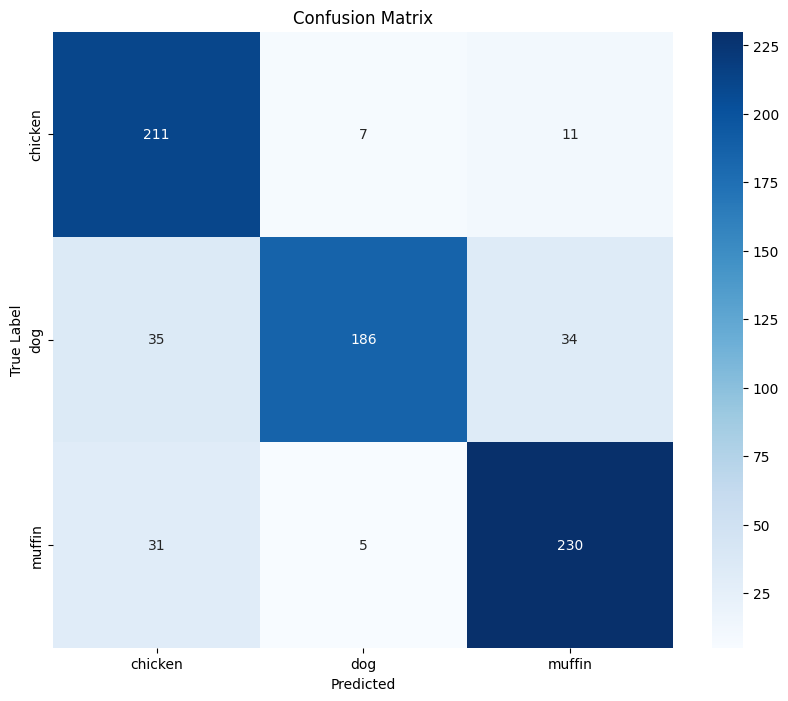

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to compute the confusion matrix
def compute_confusion_matrix(model, dataloader, num_classes, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # Disable gradients for faster inference
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch["image"], batch["label"]
            preds = model(images)
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate predictions and true labels
    all_preds = torch.cat(all_preds).argmax(dim=1)  # Get the predicted class
    all_labels = torch.cat(all_labels)

    # Initialize and compute confusion matrix with task="multiclass"
    conf_matrix_metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
    conf_matrix = conf_matrix_metric(all_preds, all_labels).cpu()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Usage:
class_names = ["chicken", "dog", "muffin"]  # Replace with actual class names
compute_confusion_matrix(model=lit_model, dataloader=datamodule.val_dataloader(), num_classes=3, class_names=class_names)

# Tasks (during practice, solved together)
1. Visualize the augmented/preprocessed training/validation images. What do we see?
2. Turn image augmentations off in the training transforms.
3. Inspect the baseline CNN. What are the output shapes after each layer?
4. Run the baseline training.
5. Remove all ReLUs from our convolutional network. What do we expect? What do we see?
6. Replace the CNN with a MobilenetV2 network. How does it perform (train vs validation)?
7. Add regularization to the training (turn on image augmentations, add weight decay, by replacing Adam with AdamW).
8. Load ImageNet-pretrained weights into the MobileNetV2 network and finetune it.
* **Warning 1**: ImageNet has 1000 classes, we only have 3. How does this affect the final layer of the network, what can we do?
* **Warning 2**: When using pretrained weights, we need to make sure that we use the same preprocessing as during pretraining. Turn pixel value normalization on in the transforms.
9. Try finetuning only the final classification layer of the network. How does this affect performance? What can be the advantages?

# Tasks (homework)
Your tasks are the following:
1. Add some other type of image augmentation to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure.
2. Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? print it out! What is the exact number of trainable parameters in the new network? print it out!
3. Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run an evaluation, and visualize the confusion matrix.
